## Standard NASCAR data

In [1]:
from bbvi_infer_2l import * 
from nascarsoft import *
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Generate soft sticky observations

In [2]:
K=4 ## state
D=2 ## latent dimension
T=1000 ## timesteps

In [3]:
zs_train, xs_train, ys_train, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.01, 
                                     scale=1, speed=1, fancy=True, gamma=0)
zs_test, xs_test, ys_test, C = generate_nascar_soft(T=T, K=K, D=D, N=10, temp=0.01, 
                                     scale=1, speed=1, fancy=True, gamma=0, emission=C)

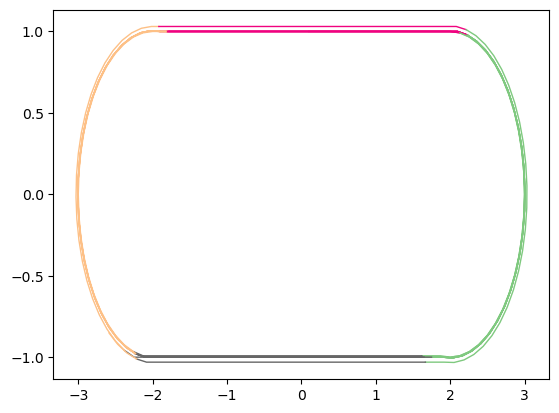

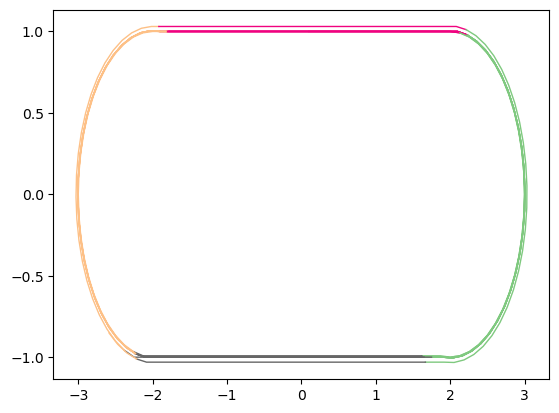

In [4]:
plot_trajectory(np.argmax(zs_train, axis=1), xs_train, ls="-")
plot_trajectory(np.argmax(zs_test, axis=1), xs_test, ls="-")

## GSD  
### GDS Train

  0%|          | 0/4000 [00:00<?, ?it/s]

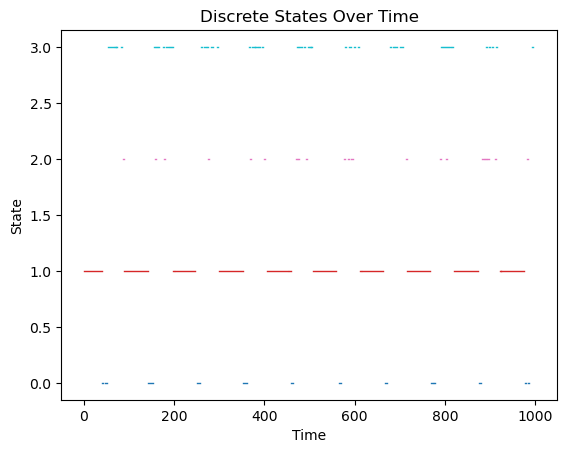

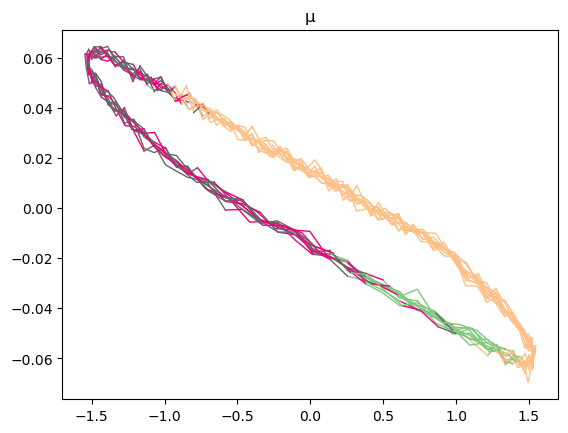

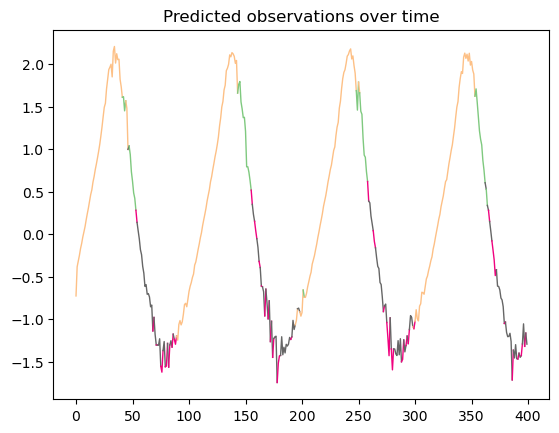

ELBO: -81791.4, LR: 0.01000, Tau: 0.990:   0%|          | 11/4000 [00:00<04:05, 16.22it/s]

R2: [-0.94686496]


ELBO: -11146.0, LR: 0.01000, Tau: 0.990:   5%|▍         | 191/4000 [00:02<00:39, 95.44it/s]/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
ELBO: -11128.6, LR: 0.01000, Tau: 0.990:   5%|▍         | 191/4000 [00:02<00:39, 95.44it/s]

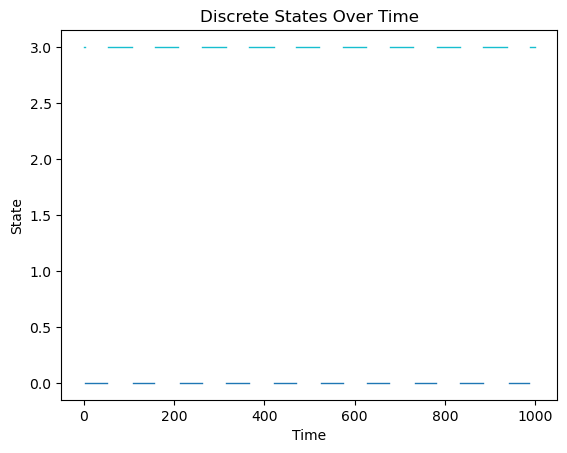

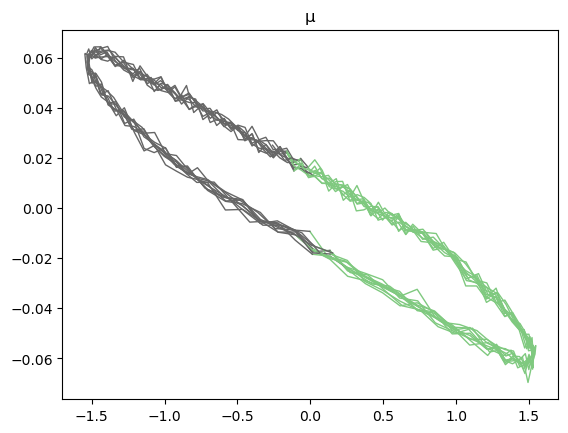

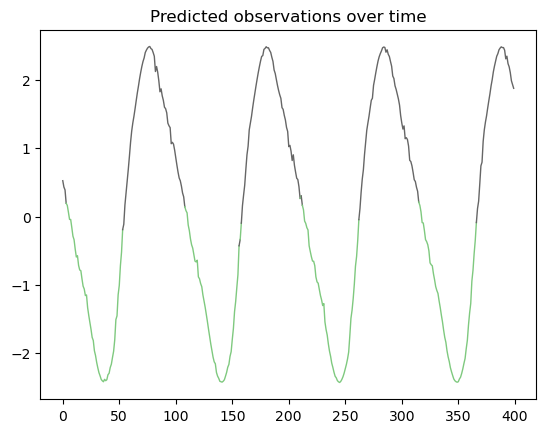

ELBO: -9742.2, LR: 0.00957, Tau: 0.990:   5%|▌         | 211/4000 [00:03<01:11, 53.08it/s] 

R2: [0.8434025]


ELBO: -3379.9, LR: 0.00550, Tau: 0.990:  10%|▉         | 391/4000 [00:05<00:37, 95.07it/s]

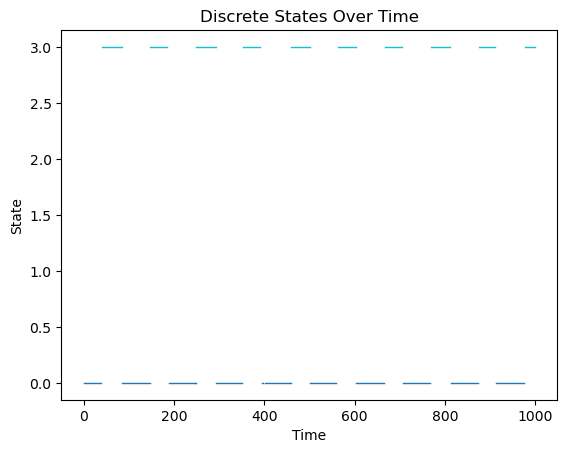

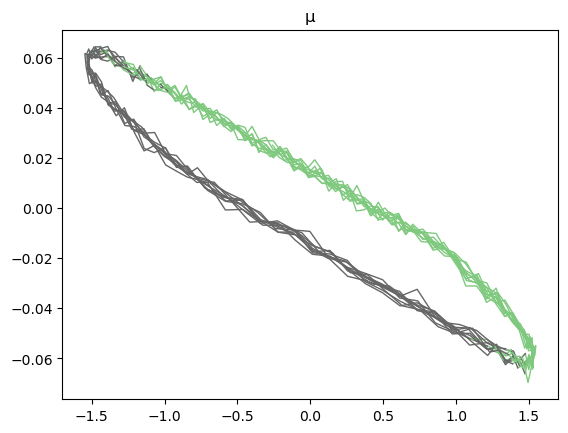

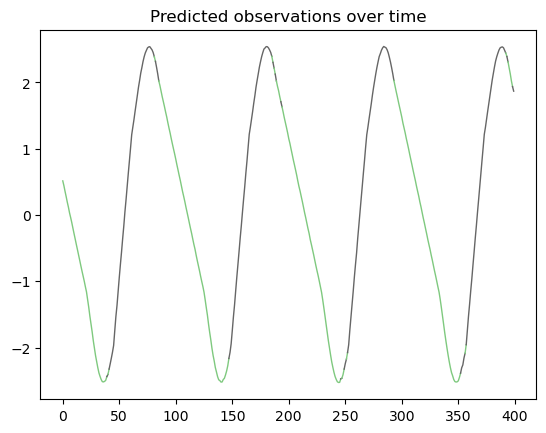

ELBO: -3002.4, LR: 0.00510, Tau: 0.990:  10%|█         | 411/4000 [00:06<01:25, 42.13it/s]

R2: [0.9760917]


ELBO: -697.6, LR: 0.00100, Tau: 0.990:  15%|█▍        | 591/4000 [00:08<00:35, 95.96it/s] 

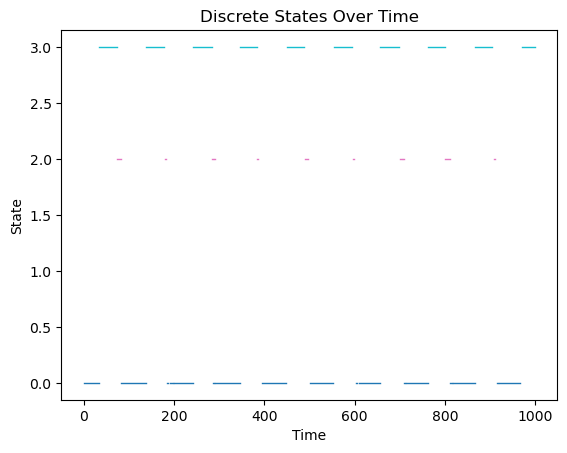

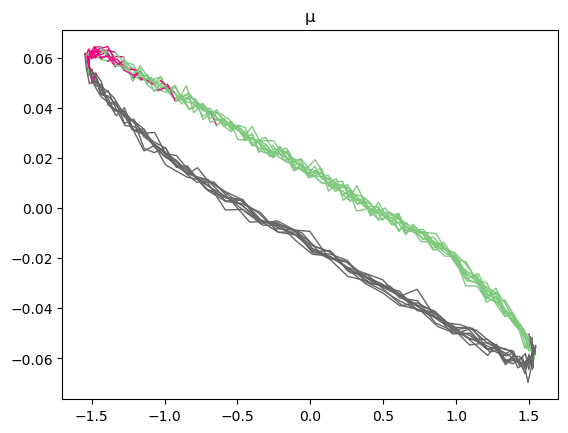

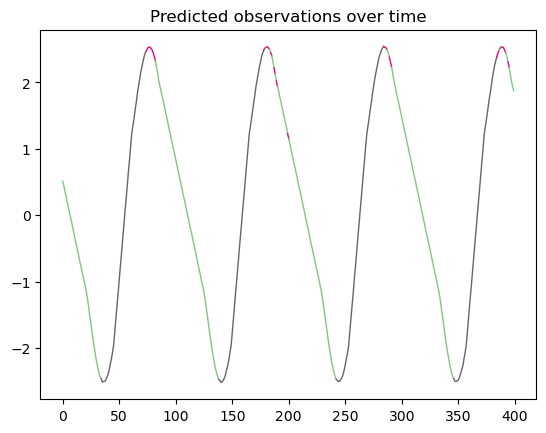

ELBO: -630.3, LR: 0.00100, Tau: 0.990:  15%|█▌        | 611/4000 [00:08<01:08, 49.38it/s]

R2: [0.9872211]


ELBO: -141.7, LR: 0.00100, Tau: 0.990:  20%|█▉        | 791/4000 [00:10<00:33, 95.70it/s]

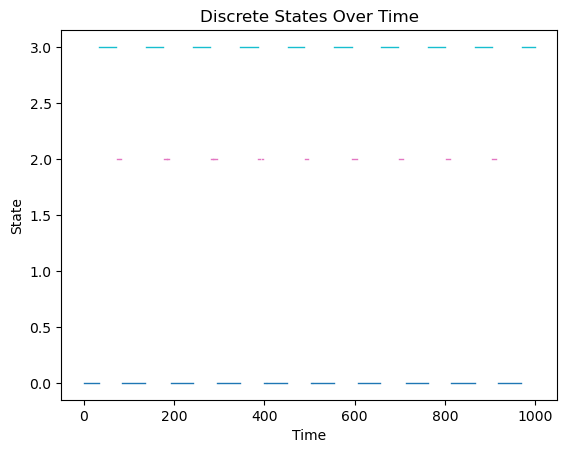

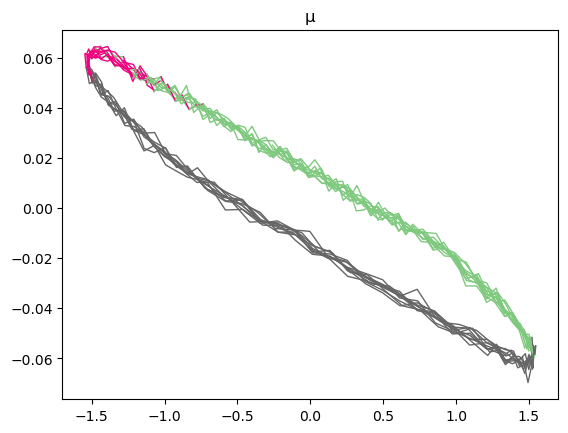

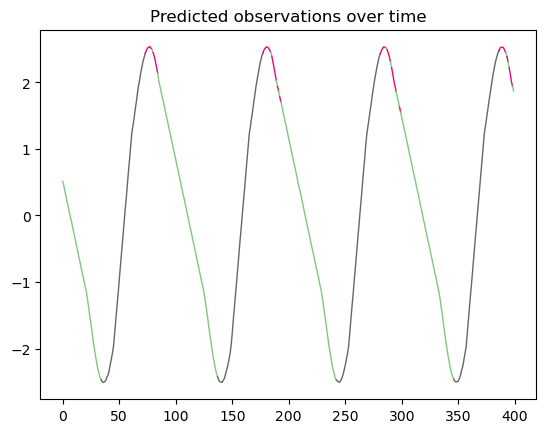

ELBO: -205.8, LR: 0.00100, Tau: 0.990:  20%|██        | 811/4000 [00:11<01:02, 50.65it/s]

R2: [0.9903525]


ELBO: 351.8, LR: 0.00100, Tau: 0.990:  25%|██▍       | 991/4000 [00:13<00:31, 96.20it/s] 

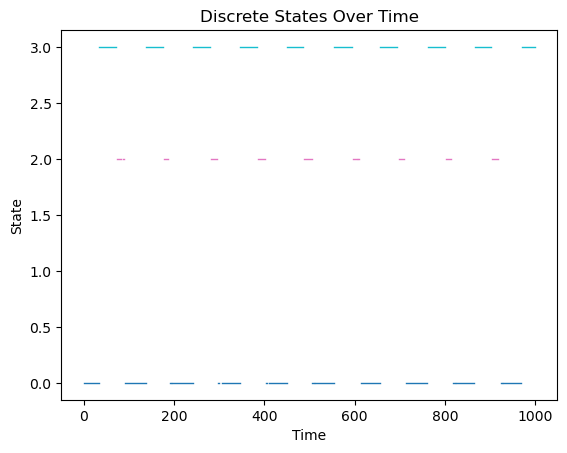

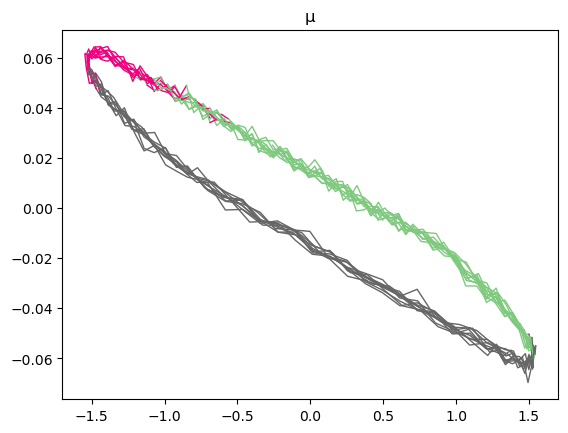

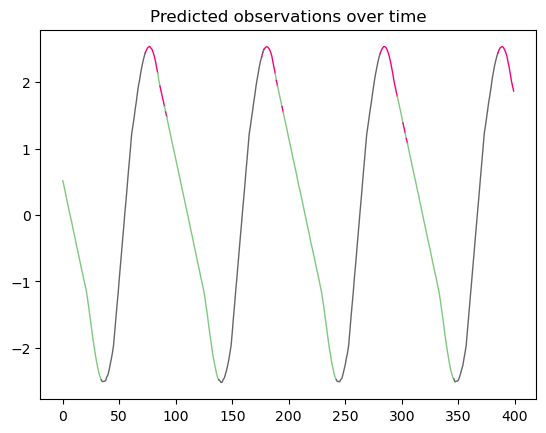

ELBO: 558.1, LR: 0.00100, Tau: 0.990:  25%|██▌       | 1011/4000 [00:13<00:59, 50.20it/s]

R2: [0.9924143]


ELBO: 511.2, LR: 0.00100, Tau: 0.990:  28%|██▊       | 1120/4000 [00:14<00:38, 75.14it/s]

Early stopping at iteration 1120.


In [5]:
model = GenerativeSLDS(N=10, K=4, D=2, emission_model="gaussian")
elbos, variational_z = fit_bbvi_schedule(model.to('cuda'), ys = torch.tensor(ys_train).to('cuda').float(), 
                                         num_iters=4000, learning=True, n_samples=10, base_lr=1e-2, 
                                         warmup_iters=200, verbose=True)

Text(0, 0.5, 'ELBO')

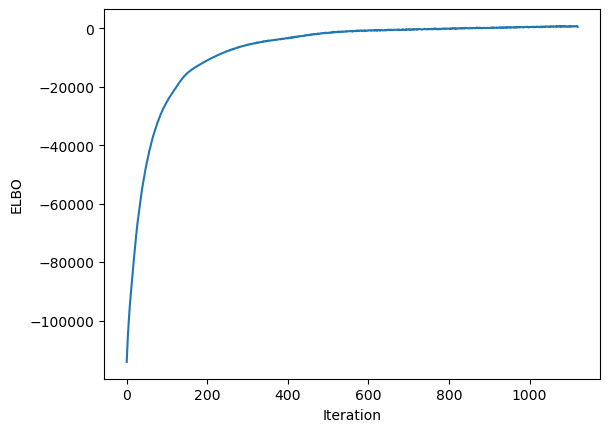

In [6]:
plt.figure()
plt.plot(elbos[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [7]:
zs = variational_z.sample_q_z(torch.tensor(ys_train).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
pred_ys0=model.smooth(torch.tensor(ys_train).to('cuda').float(), zs).mean(dim=0).detach().cpu().numpy() # [T, N]
# plot_gs_states(zs.mean(dim=0).detach().cpu().numpy())

In [8]:
y_preds, z_preds = predict_k_step_more(k_max=10, model=model, variational_z=variational_z, ys=ys_train)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9939998658637845, 0.7785356482763316, 0.7148638160613305, 0.6611071450270833, 0.5962513727838352, 0.5218067024447564, 0.4401397784871812, 0.35360465723096135, 0.26444719466668787, 0.17539899412346302, 0.08815985582510026]


### GSD Test

In [9]:
zs2 = variational_z.sample_q_z(torch.tensor(ys_test).to('cuda').float().unsqueeze(0).expand(20, -1, -1), 0.99)  ## inferred z2,..z_T
pred_ys2=model.smooth(torch.tensor(ys_test).to('cuda').float(), zs2).mean(dim=0).detach().cpu().numpy() # [T, N]
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.9940625373649835]


In [10]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = torch.mean(zs, dim=0).detach().cpu().numpy()
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = torch.mean(zs2, dim=0).detach().cpu().numpy()
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.896


### Prediction envelops

In [11]:
y_preds, z_t = predict_k_steps_full(model, variational_z, ys_test, k=2, n_trajectory=10, temperature=0.99)

Text(0.5, 1.0, '1-step-ahead predictions with ±3 std envelopes')

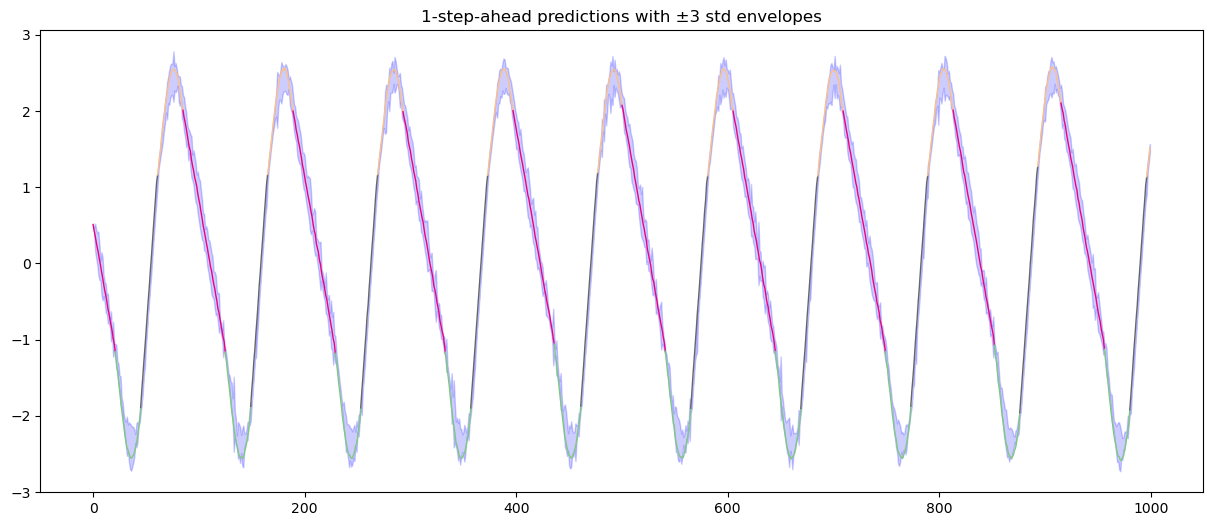

In [12]:
fig = plt.figure(figsize=(15, 6)) 
plot_observations(np.argmax(zs_test, axis=1), ys_test[:,:1],embed=False)
## 1-step-ahead with prediction envelopes
ys_array = np.array([y_preds[1][i][:,0].cpu() for i in range(100)]) 
mean = np.mean(ys_array, axis=0)
std = np.std(ys_array, axis=0)
time = np.arange(len(ys_test))
# plt.plot(time, mean, label='Mean', color='blue', linewidth=0.5)
plt.fill_between(time, mean - 3*std, mean + 3*std, color='blue', alpha=0.2, label='Std Dev')
plt.title("1-step-ahead predictions with ±3 std envelopes")

### rSLDS Recurrent Train

In [5]:
import ssm
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=D) 
rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions=sro_trans,
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(ys_train)
q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 23360.0: 100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


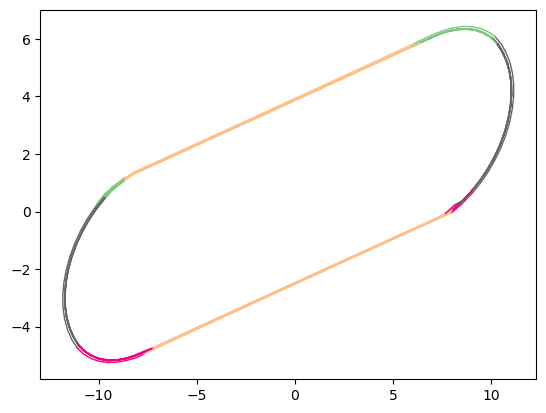

In [6]:
q_lem_x = q_lem.mean_continuous_states[0]
q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
plot_trajectory(q_lem_z, q_lem_x)

In [7]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[np.arange(T - 1), z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

In [8]:
pred_ys0 = rslds.smooth(q_lem_x, ys_train)
y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_train, k=10)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.999960108444993, 0.9999601290382311, 0.9998712197725027, 0.9995350825712107, 0.9987558164743042, 0.9973488419656708, 0.9952453564004811, 0.9920817345097406, 0.9876288407850691, 0.9818004905491373, 0.9742800957462524]


In [9]:
## no re-train allowed
pred_ys2=rslds.smooth(q_lem_x, ys_test)
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.9999579254208513]


In [10]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.687


In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.special import rel_entr  # KL divergence
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train)
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test)
# Fit on train set 
knn = KNeighborsRegressor(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
# Predict on test set 
Y_pred = knn.predict(Z_test)
# Hard accuracy 
hard_acc = accuracy_score(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))
print("Test hard accuracy:", hard_acc)

#  KL divergence on test set 
eps = 1e-8
Y_true_clip = np.clip(Y_test, eps, 1)
Y_pred_clip = np.clip(Y_pred, eps, 1)
kl_divs = np.sum(rel_entr(Y_true_clip, Y_pred_clip), axis=1)
print("Mean KL divergence on test:", kl_divs.mean())

# MSE on test set (alternative) 
mse = mean_squared_error(Y_test, Y_pred)
print("Mean squared error on test:", mse)

Test hard accuracy: 0.687
Mean KL divergence on test: 3.299826721813217
Mean squared error on test: 0.13583500000000034


### SLDS Train

In [12]:
import ssm
rslds = ssm.SLDS(N=10, K=4, D=2,
             transitions="sticky",
             dynamics="diagonal_gaussian",
             emissions="gaussian",
             single_subspace=True)
rslds.initialize(ys_train)
q_elbos_lem, q_lem = rslds.fit(ys_train, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=0.0)

ELBO: 23257.8: 100%|██████████| 100/100 [00:08<00:00, 12.10it/s]


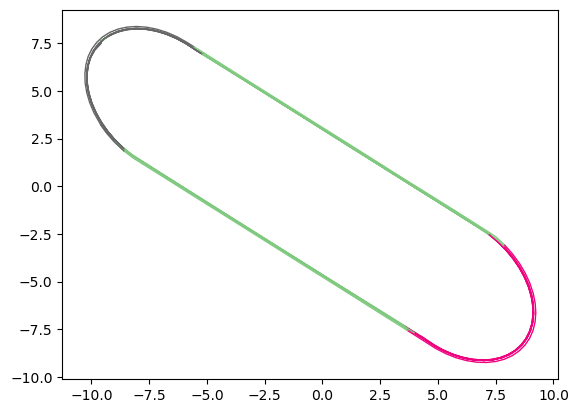

In [13]:
q_lem_x = q_lem.mean_continuous_states[0]
q_lem_z = rslds.most_likely_states(q_lem_x, ys_train)
plot_trajectory(q_lem_z, q_lem_x)

In [14]:
def slds_k_step_ahead(model, q_lem_z, q_lem_x, ys, k):
    T, N = ys.shape
    D, K = model.D, model.K
    y_preds = np.zeros((T, k, N))
    z_t = q_lem_z.copy()
    C = model.emissions.Cs[0]  # [N, D]
    d = model.emissions.ds[0]  # [N]
    for j in range(k):
        if j == 0:
            x_t = q_lem_x.copy()
        else:
            # Predict next x_t x_{t+1} = A @ x_t + b
            A = np.stack([model.dynamics.As[z] for z in z_t[j:]])  # [T, D, D]
            b = np.stack([model.dynamics.bs[z] for z in z_t[j:]])  # [T, D]
            x_t[j:] = np.einsum('tid,td->ti', A, x_t[j-1:-1]) + b  # [T, D]
        # Predict y_t
        y_preds[:, j, :] = x_t @ C.T + d  # [T, N] 
        input_dummy = np.zeros((T, model.M))  # [T-1, M]
        xmask_dummy = np.ones((T, D), dtype=bool)  # [T-1, D]
        # Compute transition probabilities
        log_Ps = model.transitions.log_transition_matrices(
            x_t, input=input_dummy, mask=xmask_dummy, tag=None)  # [T-1, K, K]
        Ps = np.exp(log_Ps)  
        # Greedy update of z_t
        z_prev = z_t[:-1]
        z_next = np.argmax(Ps[0,z_prev], axis=-1)  # [T-1]
        z_t[1:] = z_next
    return y_preds, z_t, x_t  # shape [T, k, N]

In [15]:
pred_ys0 = rslds.smooth(q_lem_x, ys_train)
y_preds, z_preds, x_preds = slds_k_step_ahead(rslds, q_lem_z, q_lem_x, ys_train, k=10)
print("Train accuracy:", train_metrics(ys_train, pred_ys0, y_preds, k_max=10))

Train accuracy: [0.9999594269181248, 0.9999594411482612, 0.9998834374756667, 0.9996028794973493, 0.9989474525540205, 0.9976862339229553, 0.9955870586322891, 0.9922432928433281, 0.9871870031513794, 0.9798438333708714, 0.9696384491160076]


In [16]:
pred_ys2=rslds.smooth(q_lem_x, ys_test)
print("Test accuracy:", train_metrics(ys_test, pred_ys2, None, k_max=0))

Test accuracy: [0.9999580086613689]


In [17]:
### State quality
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
Z_train = np.eye(4)[q_lem_z]
Y_train = np.array(zs_train.argmax(axis=1))
Z_test = np.eye(4)[q_lem_z]
Y_test = np.array(zs_test.argmax(axis=1))
# Train KNN classifier
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean')
knn.fit(Z_train, Y_train)
acc = knn.score(Z_test, Y_test)
print("Test accuracy:", acc)

Test accuracy: 0.833
